In [131]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
    
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
import easing
from collections import Counter
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

sys.path.append('../Utility_Scripts/')
from synthetic_data_generator import MLR,meal_income
from ensemble_methods import EnsembleModel
import matplotlib.patches as mpatches
from training_on_uncertainty import PCA_binning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# load ML packages

from sklearn.model_selection import KFold,train_test_split,LeaveOneOut,StratifiedKFold,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
from matplotlib.patches import Rectangle as rec
from easing import easing


![fig](../media/training_uncertainty_schema.png)
This approach to UQ relies on having a model explicity trained to predict the uncertainty in a value, not simply the vairance around its predictions. 

# Basic analysis : Linear Regression trained to predict value and uncertainty simultaneously (2 outputs) // manual binning
![fig](figures/binned_example.png)

See code below for figure generation


In [102]:
%%capture
meal_income_df=meal_income(size=1000,return_df=True)
colors_h=sns.color_palette("husl", 2)
colors_r=sns.color_palette("rainbow", 2)


###plotting emperical data
fig,ax=plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
ax[0].scatter(meal_income_df['X'],meal_income_df['y'],color='#d3d3d3')
bins=np.append(np.arange(0,100,10),100)
for b in bins:
    ax[0].plot([b,b],[0,100],color='black')
ax[0].set_title('Emperical Data \n (binned)')
ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Normalized Cost of Last Meal')



### binning data
X_y_df=meal_income_df[['X','y']]
X_y_df.loc[:,'bins']=np.digitize(X_y_df.X, bins, right=True)
Binned_df=X_y_df.groupby('bins').mean().rename(columns={'X':'X_mean','y':'y_mean'})
Binned_df.loc[:,'y_std']=X_y_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']

ax[1].errorbar(Binned_df['X_mean'],Binned_df['y_mean'],yerr=Binned_df['y_std'],fmt='o',color=colors_h[0],ecolor=colors_h[1])
ax[1].set_title('Summary Statistics of \n Binned Data')
recs=[]
for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors_h[j]))
ax[1].legend(recs, ['Mean y value','STD y value'], loc='upper right')
ax[1].set_xlabel('Normalized Annual Income')
ax[1].set_ylabel('Normalized Cost of Last Meal')
fig.savefig('figures/binned_example.png',bbox_inches='tight',dpi=300)



# training a model on this

In [111]:
# generating and splitting data
meal_income_df=meal_income(size=1000,return_df=True)   
Train, test = train_test_split(meal_income_df, test_size=0.1,random_state=88)

### convert training data into learnable uncertainty
X_y_df=Train[['X','y']]
X_y_df.loc[:,'bins']=np.digitize(X_y_df.X, np.arange(100)+1, right=True)

Binned_df=X_y_df.groupby('bins').mean().rename(columns={'X':'X_mean','y':'y_mean'})
Binned_df.loc[:,'y_std']=X_y_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [107]:
model = LinearRegression()
X=Binned_df.X_mean.values.reshape(-1, 1)
y=Binned_df[['y_mean','y_std']].values
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [108]:
predicted_values=model.predict(test['X'].values.reshape(-1,1))

Text(0.5, 1.0, 'Error vs Uncertainty')

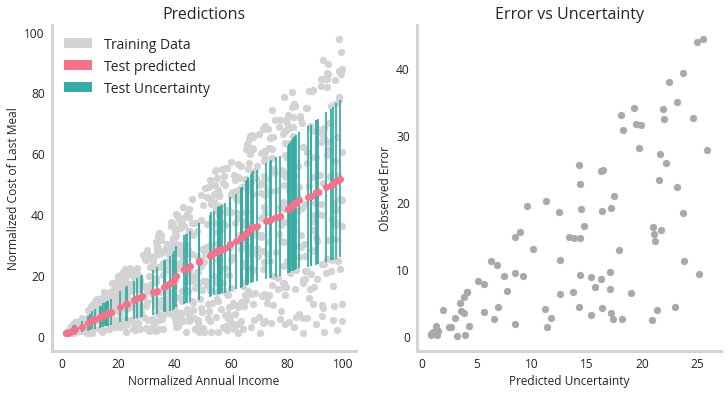

In [121]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(Train['X'].ravel(),Train['y'].ravel(),color='#d3d3d3')

ax[0].errorbar(test['X'].values,predicted_values[:,0],yerr=predicted_values[:,1],fmt='o',color=colors_h[0],ecolor=colors_h[1])


recs=[mpatches.Rectangle((0, 0), 1, 1, fc='#d3d3d3')]
for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors_h[j]))
ax[0].legend(recs, ['Training Data','Test predicted','Test Uncertainty'], loc='upper left')
ax[0].set_xlabel('Normalized Annual Income')
ax[0].set_ylabel('Normalized Cost of Last Meal')
ax[0].set_title('Predictions')

errors=abs(test['y'].values-predicted_values[:,0])

ax[1].scatter(predicted_values[:,1],errors,color='darkgrey')
ax[1].set_xlabel('Predicted Uncertainty')
ax[1].set_ylabel('Observed Error')
ax[1].set_title('Error vs Uncertainty')



In [116]:
abs(test['y'].values-predicted_values[:,0])

array([ 0.15187551, 44.04938812, 14.74811765, 14.83556736,  4.37798625,
        9.38497586, 25.62855719, 19.21015192, 25.8544755 , 18.97679114,
       15.55465248,  6.43266347, 18.56131678, 27.85626065,  2.65655148,
        3.17870184, 10.61314582, 35.02661499, 16.31924653,  9.44481189,
        4.14987658, 33.94824075, 31.75568129, 32.66762188,  1.51680666,
       22.78996293,  0.21755536, 37.96483588, 22.2642336 ,  1.81581268,
       15.28403891, 11.29556416, 34.114975  , 15.9130221 , 18.72307617,
        2.61559276, 14.78451825, 20.18437764,  9.67570009,  0.18449533,
       27.2259705 , 20.92669894,  9.20754787, 11.20179902,  9.06746979,
        0.41937768, 12.91754306,  7.09382536, 19.52786478,  0.44592274,
        3.50400527,  8.95267988,  2.77774895, 16.42401425,  2.6484858 ,
        6.59379244,  3.91511219, 11.43363566, 14.66184124, 24.90124067,
       13.10208683,  3.92326567,  6.80403648, 23.38567741,  1.42089474,
        3.58600027, 30.76547971, 44.35432108, 28.14947473,  6.60

Text(0.5, 1.0, 'Model Predictions for Mean and STD \n mean and Standard Deviation')

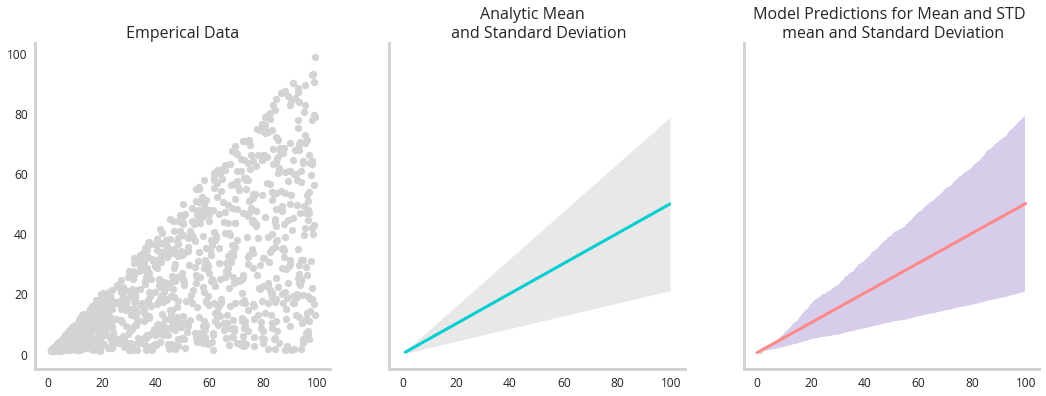

In [9]:
fig,ax=plt.subplots(1,3,figsize=(18,6),sharex=True,sharey=True)
ax[0].scatter(meal_income_df['X'].ravel(),meal_income_df['y'].ravel(),color='#d3d3d3')


x_values=meal_income_dict['X']
mu=meal_income_dict['mu']
sigma=meal_income_dict['sigma']

ax[1].plot(x_values.ravel(), mu,linewidth=3,color='darkturquoise')
ax[1].fill_between(x_values.ravel(), mu - sigma, mu + sigma, alpha=0.5,color='#d3d3d3')

x_vect=np.linspace(0,100,1000).reshape(-1,1)
predicted_values=model.predict(x_vect)
ax[2].plot(x_vect, predicted_values[:,0],linewidth=3,color='#FF8889')

minus_std=predicted_values[:,0]-predicted_values[:,1]
plus_std=predicted_values[:,0]+predicted_values[:,1]

ax[2].fill_between(x_values.ravel(),minus_std,plus_std , alpha=0.5,color='#b19cd9')

ax[0].set_title('Emperical Data')
ax[1].set_title('Analytic Mean  \n and Standard Deviation')
ax[2].set_title('Model Predictions for Mean and STD \n mean and Standard Deviation')

# Multiple Feature Dimensions and More powerful models

In [31]:
# Multiple X dimensions
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
#X,y=make_regression(n_samples=1000, n_features=10, n_targets=1,random_state=88)

# creating multidimensional bi


In [129]:
# creating multidimensional bi

meal_income_df=meal_income(size=1000,return_df=True)
meal_income_df=meal_income_df.rename(columns={'X':'X1'})
meal_income_df['X2']=meal_income_dict2['X'][::-1]

In [133]:
reduced_df,binned_df=PCA_binning(meal_income_df,
                                 x_cols=['X1','X2'],
                                 y_col='y'
                                )

In [57]:
pca = PCA(n_components=1)
meal_income_df['PCA_values']=pca.fit_transform(meal_income_df[['X1','X2']])

In [58]:
bins=np.linspace(min(meal_income_df['PCA_values']),max(meal_income_df['PCA_values']),100)
meal_income_df['bins']=np.digitize(meal_income_df['PCA_values'], bins=bins, right=True)


Text(0, 0.5, 'Normalized Cost of Last Meal')

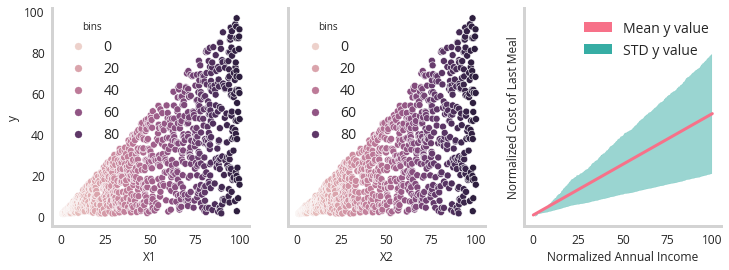

In [71]:
Binned_df=meal_income_df.groupby('bins').mean().rename(columns={'X1':'X1_mean','y':'y_mean','X2':'X2_mean'})
Binned_df.loc[:,'y_std']=X_y_df.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']

fig,ax=plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)


sns.scatterplot(x='X1',y='y',hue='bins',data=meal_income_df,ax=ax[0])
sns.scatterplot(x='X2',y='y',hue='bins',data=meal_income_df,ax=ax[1])

Binned_df=Binned_df.fillna(0)
model = LinearRegression()
X=Binned_df[['X1_mean','X2_mean']].values
y=Binned_df[['y_mean','y_std']].values
model.fit(X,y)

ax[2].plot(x_vect, predicted_values[:,0],linewidth=3,color=colors_h[0])

minus_std=predicted_values[:,0]-predicted_values[:,1]
plus_std=predicted_values[:,0]+predicted_values[:,1]

ax[2].fill_between(x_values.ravel(),minus_std,plus_std , alpha=0.5,color=colors_h[1])

for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors_h[j]))
ax[2].legend(recs, ['Mean y value','STD y value'], loc='upper right')
ax[2].set_xlabel('Normalized Annual Income')
ax[2].set_ylabel('Normalized Cost of Last Meal')


Text(0, 0.5, 'Normalized Cost of Last Meal')

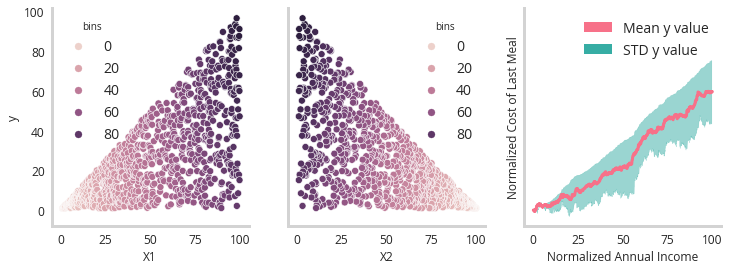

In [97]:
meal_income_df_flipped=meal_income_df.copy()
meal_income_df_flipped['X2']=meal_income_df_flipped['X2'][::-1].values
pca = PCA(n_components=2)
meal_income_df_flipped['PCA_values']=pca.fit_transform(meal_income_df_flipped[['X1','X2','y']])[:,0]
bins=np.linspace(min(meal_income_df_flipped['PCA_values']),max(meal_income_df_flipped['PCA_values']),100)
meal_income_df_flipped['bins']=np.digitize(meal_income_df_flipped['PCA_values'], bins=bins, right=True)


Binned_df=meal_income_df_flipped.groupby('bins').mean().rename(columns={'X1':'X1_mean','y':'y_mean','X2':'X2_mean'})
Binned_df.loc[:,'y_std']=meal_income_df_flipped.groupby('bins').std().rename(columns={'y':'y_std'})['y_std']
fig,ax=plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)


sns.scatterplot(x='X1',y='y',hue='bins',data=meal_income_df_flipped,ax=ax[0])
sns.scatterplot(x='X2',y='y',hue='bins',data=meal_income_df_flipped,ax=ax[1])

Binned_df=Binned_df.fillna(0)
model = LinearRegression()
X=Binned_df[['X1_mean','X2_mean']].values
y=Binned_df[['y_mean','y_std']].values
model.fit(X,y)
predicted_values=model.predict(meal_income_df_flipped[['X1','X2']].values)


ax[2].plot(x_vect, predicted_values[:,0],linewidth=3,color=colors_h[0])

minus_std=predicted_values[:,0]-predicted_values[:,1]
plus_std=predicted_values[:,0]+predicted_values[:,1]

ax[2].fill_between(x_values.ravel(),minus_std,plus_std , alpha=0.5,color=colors_h[1])

for j in range(2):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors_h[j]))
ax[2].legend(recs, ['Mean y value','STD y value'], loc='upper right')
ax[2].set_xlabel('Normalized Annual Income')
ax[2].set_ylabel('Normalized Cost of Last Meal')


In [90]:
pca = PCA(n_components=2)
pca.fit_transform(meal_income_df_flipped[['X1','X2']])[:,1]

array([-1.62908002e+00, -1.61236338e+00, -1.56653995e+00, -1.51523700e+00,
       -1.54619722e+00, -1.42169015e+00, -1.32990416e+00, -1.40069057e+00,
       -1.18188201e+00, -1.22574452e+00, -1.27418330e+00, -1.28822443e+00,
       -1.40855424e+00, -1.36565270e+00, -1.48779773e+00, -1.50188349e+00,
       -1.45060170e+00, -1.45946771e+00, -1.80576193e+00, -1.81638559e+00,
       -1.79906625e+00, -1.87029888e+00, -1.92828000e+00, -1.92146131e+00,
       -1.93977647e+00, -1.90313816e+00, -1.99554432e+00, -1.99185600e+00,
       -1.79760152e+00, -1.78247229e+00, -1.72102095e+00, -1.84943008e+00,
       -1.94680178e+00, -1.92812996e+00, -1.89939299e+00, -1.93947869e+00,
       -1.89880338e+00, -1.83464686e+00, -1.74677681e+00, -1.66405533e+00,
       -1.67555430e+00, -1.65697770e+00, -1.55215643e+00, -1.55276264e+00,
       -1.43072983e+00, -1.43931339e+00, -1.40804984e+00, -1.24739869e+00,
       -1.28178797e+00, -1.27758055e+00, -1.22295081e+00, -1.04237504e+00,
       -1.15183241e+00, -

In [128]:
np.roll(x_values.reshape(-1,1),10)

array([[98.60929966],
       [98.72254608],
       [98.8655835 ],
       [98.87448461],
       [98.87767445],
       [98.89524287],
       [99.11139775],
       [99.19028298],
       [99.35428428],
       [99.46498549],
       [ 1.00802234],
       [ 1.03040702],
       [ 1.1600978 ],
       [ 1.1633065 ],
       [ 1.51149096],
       [ 1.61315071],
       [ 1.8238502 ],
       [ 1.87241354],
       [ 1.9039594 ],
       [ 1.91093831],
       [ 2.0399654 ],
       [ 2.04698633],
       [ 2.04853281],
       [ 2.10297645],
       [ 2.20319408],
       [ 2.27827373],
       [ 2.55795638],
       [ 2.708444  ],
       [ 2.86960929],
       [ 2.87382845],
       [ 2.94874139],
       [ 2.97124871],
       [ 3.01053211],
       [ 3.18173908],
       [ 3.20231752],
       [ 3.39717943],
       [ 3.60943121],
       [ 3.66124935],
       [ 3.75931882],
       [ 3.89582533],
       [ 3.98051151],
       [ 4.0404711 ],
       [ 4.09650781],
       [ 4.12286845],
       [ 4.13768793],
       [ 4